In [ ]:
from functools import partial

import numpy as np
import albumentations as A
from fastai.data.transforms import Normalize
from fastai.vision.augment import (
    Resize,
    aug_transforms,
    imagenet_stats,
    RandomResizedCrop,
    RandTransform
)
from fastai.vision.core import PILImage
from fastcore.basics import store_attr

from tsp_cls.utils.root import get_data_root
from tsp_cls.utils.data import (
    get_image_path,
    field_getter,
    read_dataframe,
    sample_dataframe,
)
from tsp_cls.dataloader.dataloader import get_dls

In [ ]:
path = get_data_root()

In [ ]:
path = get_data_root()

In [ ]:
print(f"Length of DF: {len(df)}")

Length of DF: 22396


In [ ]:
item_tfms = [Resize(460)]
batch_tfms = [
        Normalize.from_stats(*imagenet_stats),
]

In [ ]:
dls = get_dls(
        df,
        get_x=partial(
            partial(get_image_path, data_path=path), data_path=get_data_root()
        ),
        get_y=partial(field_getter, field="genus"),
        item_tfms=item_tfms,
        batch_tfms=batch_tfms,
        bs=64,
)

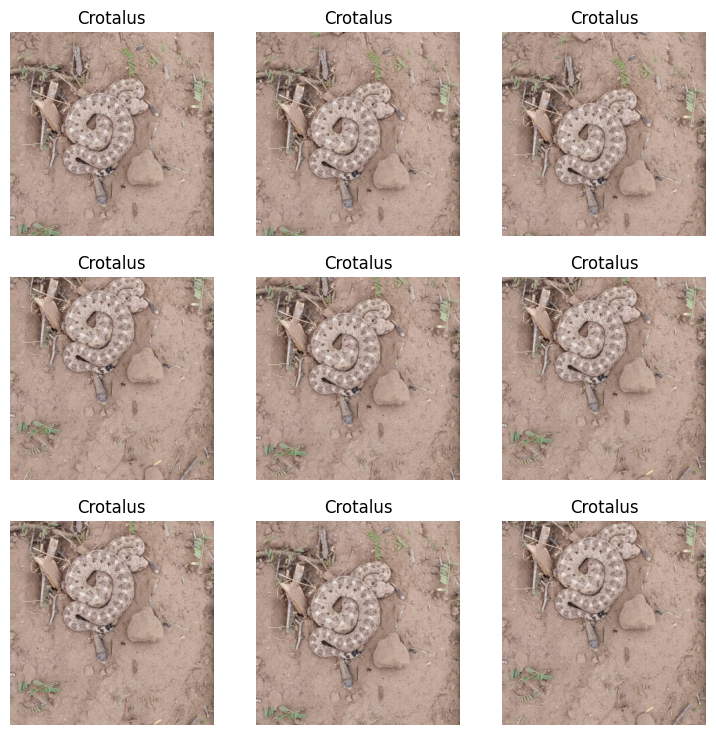

In [ ]:
dls.show_batch(unique=True)

In [ ]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([64, 3, 460, 460]), torch.Size([64]))

In [ ]:
batch_tfms

[Normalize -- {'mean': tensor([[[[0.4850]],
 
          [[0.4560]],
 
          [[0.4060]]]], device='cuda:0'), 'std': tensor([[[[0.2290]],
 
          [[0.2240]],
 
          [[0.2250]]]], device='cuda:0'), 'axes': (0, 2, 3)}:
 encodes: (TensorImage,object) -> encodes
 decodes: (TensorImage,object) -> decodes]

Let us try out some augmentations:

a) Random Resized Crop

In [ ]:
item_tfms = [Resize(460)]
batch_tfms = [
        RandomResizedCrop(size=224, min_scale=0.75),
        Normalize.from_stats(*imagenet_stats),
]

dls = get_dls(
        df,
        get_x=partial(
            partial(get_image_path, data_path=path), data_path=get_data_root()
        ),
        get_y=partial(field_getter, field="genus"),
        item_tfms=item_tfms,
        batch_tfms=batch_tfms,
        bs=64,
)

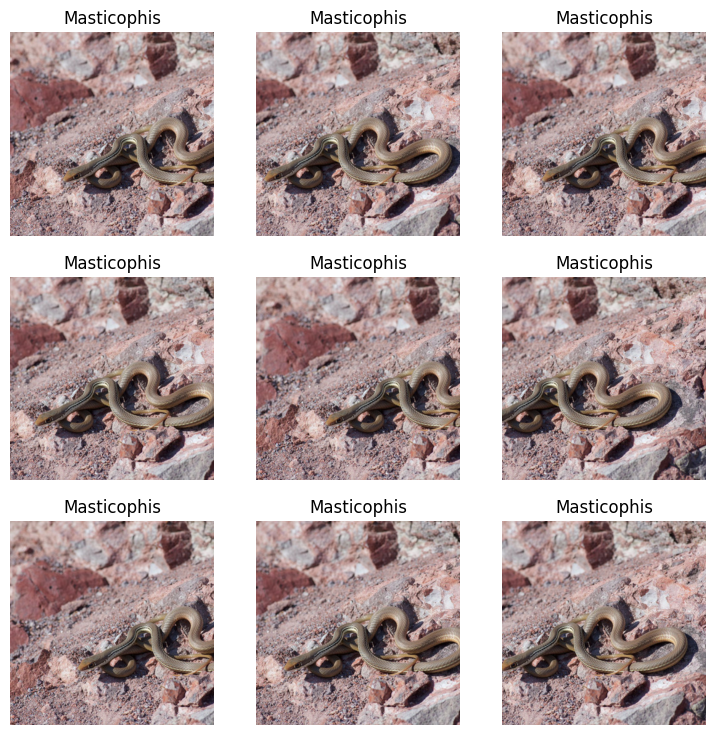

In [ ]:
dls.show_batch(unique=True)

In [ ]:
batch_tfms

[RandomResizedCrop -- {'size': (224, 224), 'min_scale': 0.75, 'ratio': (0.75, 1.3333333333333333), 'resamples': (<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>), 'val_xtra': 0.14, 'max_scale': 1.0, 'p': 1.0}:
 encodes: (Image,object) -> encodes
 (TensorBBox,object) -> encodes
 (TensorPoint,object) -> encodes
 decodes: ,
 Normalize -- {'mean': tensor([[[[0.4850]],
 
          [[0.4560]],
 
          [[0.4060]]]], device='cuda:0'), 'std': tensor([[[[0.2290]],
 
          [[0.2240]],
 
          [[0.2250]]]], device='cuda:0'), 'axes': (0, 2, 3)}:
 encodes: (TensorImage,object) -> encodes
 decodes: (TensorImage,object) -> decodes]

In [ ]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([64, 3, 460, 460]), torch.Size([64]))

b) aug_transforms

In [ ]:
item_tfms = [Resize(460)]
batch_tfms = [
        *aug_transforms(size=224, min_scale=0.75, mult=1.5),
        Normalize.from_stats(*imagenet_stats),
]

dls = get_dls(
        df,
        get_x=partial(
            partial(get_image_path, data_path=path), data_path=get_data_root()
        ),
        get_y=partial(field_getter, field="genus"),
        item_tfms=item_tfms,
        batch_tfms=batch_tfms,
        bs=64,
)

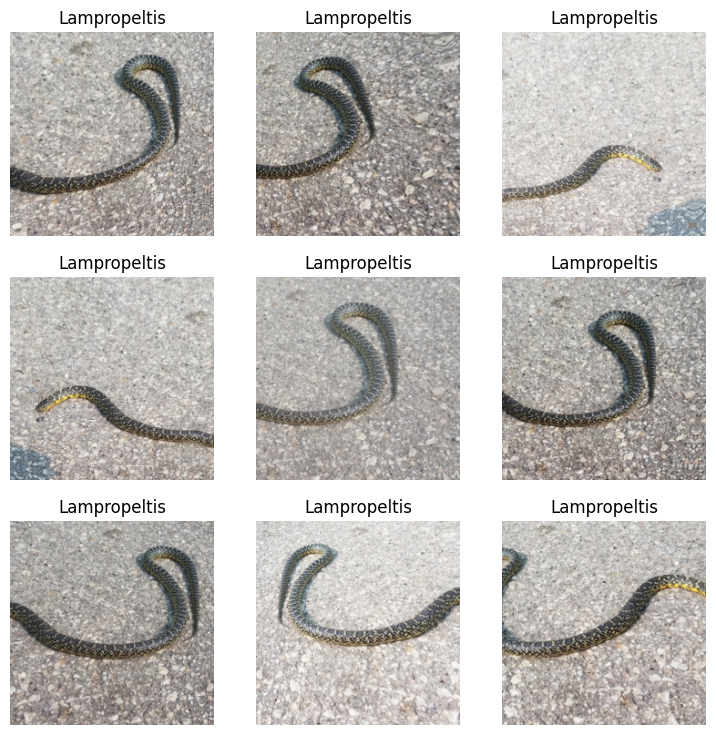

In [ ]:
dls.show_batch(unique=True)

In [ ]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

In [ ]:
batch_tfms

[Flip -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5}:
 encodes: (TensorImage,object) -> encodes
 (TensorMask,object) -> encodes
 (TensorBBox,object) -> encodes
 (TensorPoint,object) -> encodes
 decodes: ,
 Brightness -- {'max_lighting': 0.30000000000000004, 'p': 1.0, 'draw': None, 'batch': False}:
 encodes: (TensorImage,object) -> encodes
 decodes: ,
 RandomResizedCropGPU -- {'size': (224, 224), 'min_scale': 0.75, 'ratio': (1, 1), 'mode': 'bilinear', 'valid_scale': 1.0, 'max_scale': 1.0, 'mode_mask': 'nearest', 'p': 1.0}:
 encodes: (TensorImage,object) -> encodes
 (TensorBBox,object) -> encodes
 (TensorPoint,object) -> encodes
 (TensorMask,object) -> encodes
 decodes: ,
 Normalize -- {'mean': tensor([[[[0.4850]],
 
          [[0.4560]],
 
          [[0.4060]]]], device='cuda:0'), 'std': tensor([[[[0.2290]],
 
          [[0.2240]],
 
          [[0.2250]]]], device='cuda:0'), 'axes': (0, 2, 3)}:
 encodes: (TensorIm

c) Albumentations

In [ ]:
class AlbumentationsTransform(RandTransform):
    "A transform handler for multiple `Albumentation` transforms"
    split_idx,order=None,2
    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

In [ ]:
def get_train_aug(): return A.Compose([
            A.RandomResizedCrop(224,224),
            A.Transpose(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(p=0.5),
            # A.CoarseDropout(p=0.5)
])

def get_valid_aug(): return A.Compose([
    A.CenterCrop(224,224, p=1.),
    A.Resize(224,224)
], p=1.)

In [ ]:
item_tfms = [Resize(256), AlbumentationsTransform(get_train_aug(), get_valid_aug())]
batch_tfms = [Normalize.from_stats(*imagenet_stats)]

dls = get_dls(
        df,
        get_x=partial(
            partial(get_image_path, data_path=path), data_path=get_data_root()
        ),
        get_y=partial(field_getter, field="genus"),
        item_tfms=item_tfms,
        batch_tfms=batch_tfms,
        bs=64,
)

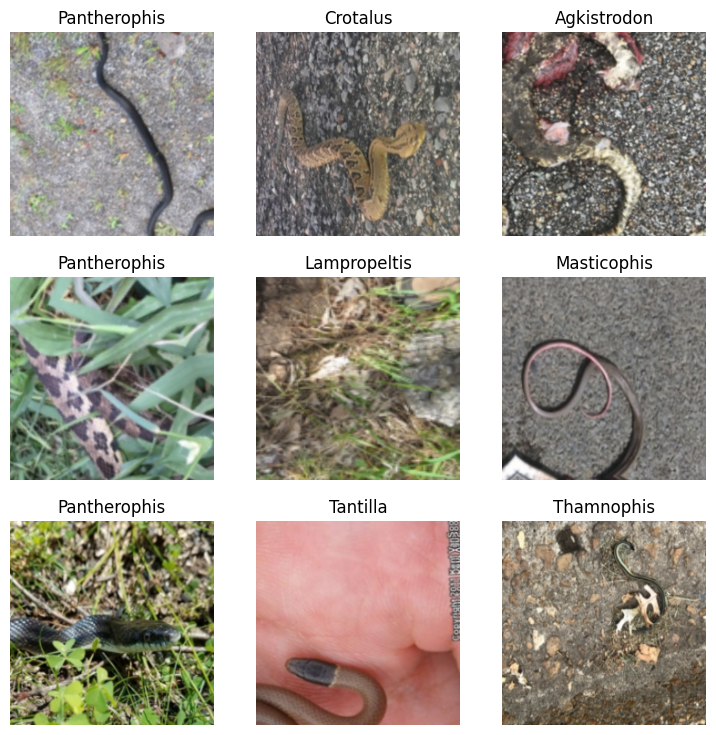

In [ ]:
dls.train.show_batch()

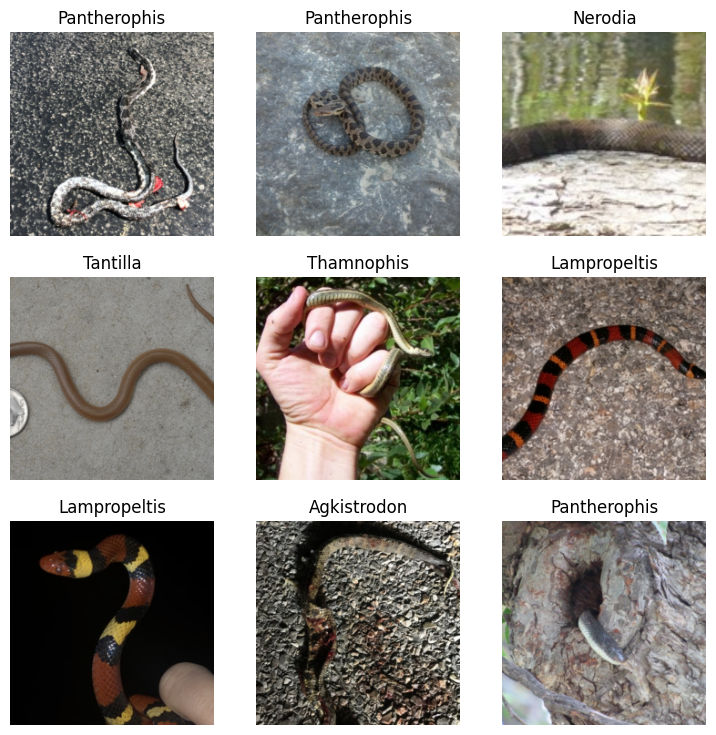

In [ ]:
dls.valid.show_batch()

In [ ]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))